# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [11]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [12]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [13]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=None):
        y = tf.matmul(x, self.w) + self.b
        if activation:
          return activation(y)
        return y


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Выходной слой
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    x = self.layer_1(x, tf.nn.sigmoid)
    x = self.layer_2(x, tf.nn.sigmoid)
    x = self.layer_3(x, tf.nn.softmax)


    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    return x

In [14]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    predicted_labels = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicted_labels, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [17]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

optimizer = tf.optimizers.SGD(learning_rate)
loss_history = []
accuracy_history = []

# Функция обучения нейросети
@tf.function
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск


  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    trainable_variables = neural_net.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [18]:
# Тренировка сети

# каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
# каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        batch_loss = cross_entropy(pred, batch_y)
        batch_accuracy = accuracy(pred, tf.cast(batch_y, tf.int64))
        loss_history.append(batch_loss)
        accuracy_history.append(batch_accuracy)

        print(f"Step {step}, Loss: {batch_loss}, Accuracy: {batch_accuracy}")

Step 0, Loss: 3226.63720703125, Accuracy: 0.13671875
Step 100, Loss: 356.17138671875, Accuracy: 0.671875
Step 200, Loss: 190.2664337158203, Accuracy: 0.796875
Step 300, Loss: 185.23260498046875, Accuracy: 0.8046875
Step 400, Loss: 162.66952514648438, Accuracy: 0.8046875
Step 500, Loss: 142.64549255371094, Accuracy: 0.87109375
Step 600, Loss: 163.41864013671875, Accuracy: 0.83984375
Step 700, Loss: 105.35238647460938, Accuracy: 0.8984375
Step 800, Loss: 104.50898742675781, Accuracy: 0.86328125
Step 900, Loss: 123.90101623535156, Accuracy: 0.86328125
Step 1000, Loss: 121.24533081054688, Accuracy: 0.86328125
Step 1100, Loss: 80.83866882324219, Accuracy: 0.8984375
Step 1200, Loss: 94.00247192382812, Accuracy: 0.89453125
Step 1300, Loss: 71.97238159179688, Accuracy: 0.91015625
Step 1400, Loss: 109.3310317993164, Accuracy: 0.890625
Step 1500, Loss: 96.60737609863281, Accuracy: 0.87109375
Step 1600, Loss: 76.91327667236328, Accuracy: 0.91796875
Step 1700, Loss: 55.40171813964844, Accuracy: 0.

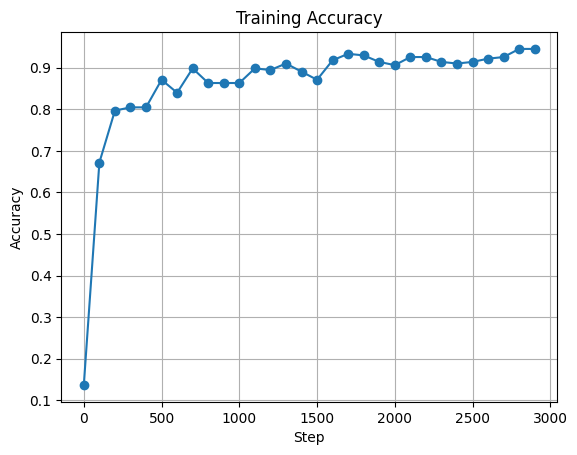

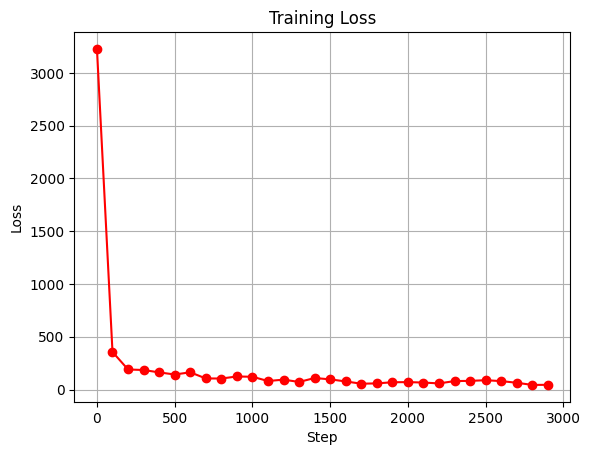

In [19]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

import matplotlib.pyplot as plt

# Вывод графика точности
plt.plot(range(0, training_steps, display_step), accuracy_history, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

# Вывод графика потерь
plt.plot(range(0, training_steps, display_step), loss_history, marker='o', color='r')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [21]:
# Вычислите точность обученной нейросети

total_accuracy = 0.0
num_test_samples = len(x_test)

for i in range(num_test_samples):
    test_sample = x_test[i:i+1]
    true_label = y_test[i]

    prediction = neural_net(test_sample)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

    if predicted_label == true_label:
        total_accuracy += 1.0

final_accuracy = total_accuracy / num_test_samples
print(f"Final Test Accuracy: {final_accuracy * 100:.2f}%")

Final Test Accuracy: 90.28%


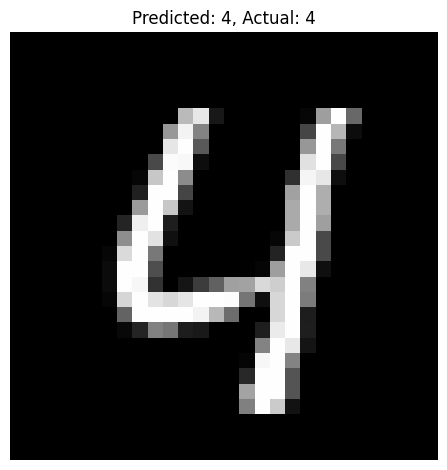

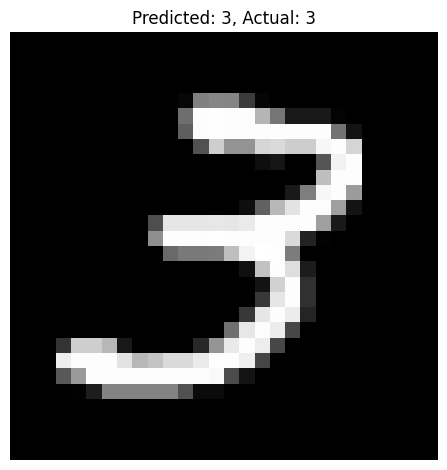

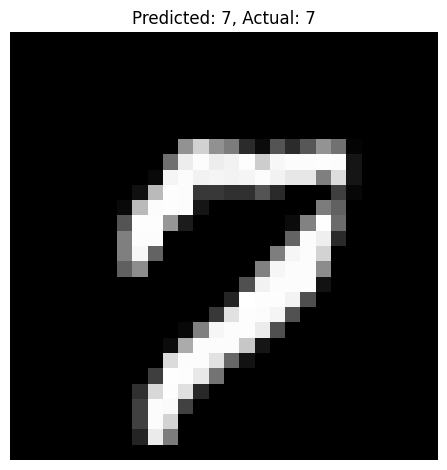

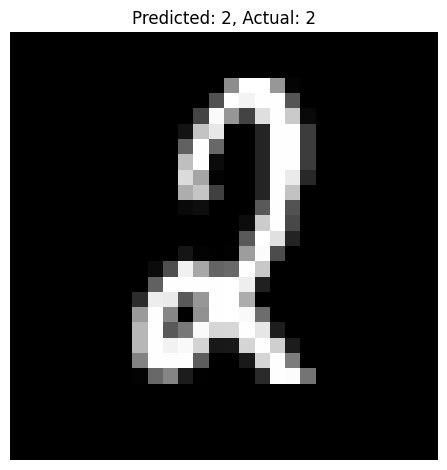

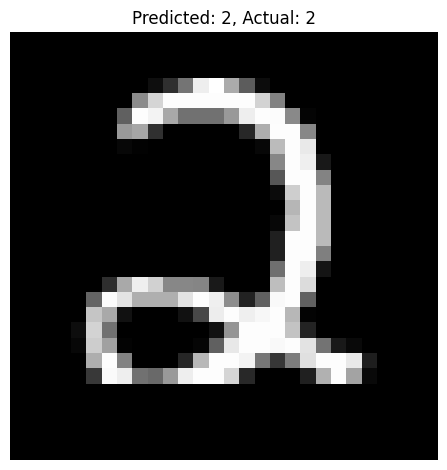

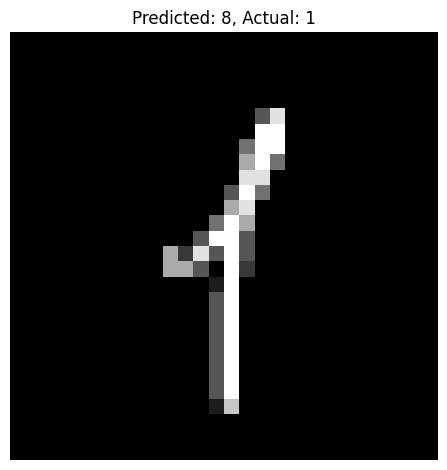

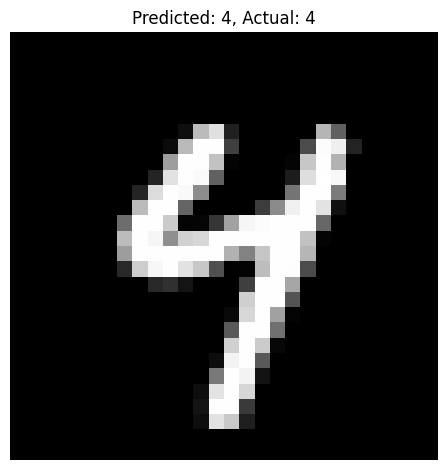

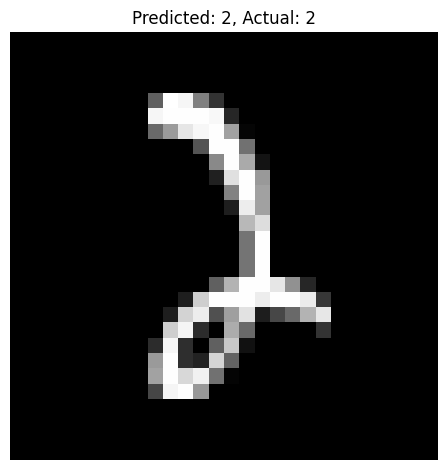

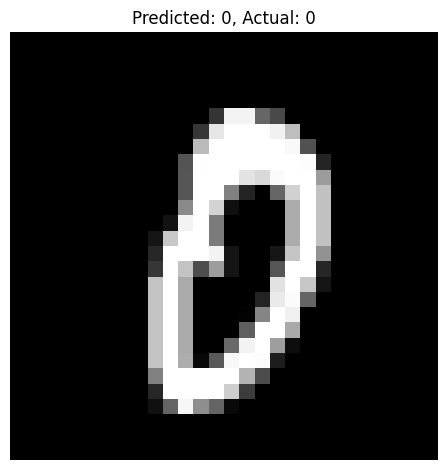

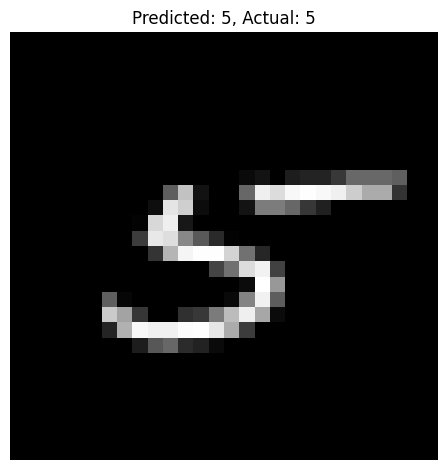

In [25]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

num_test_images = 10
random_indices = np.random.choice(len(x_test), num_test_images, replace=False)
test_samples = x_test[random_indices]
test_labels = y_test[random_indices]

for i in range(num_test_images):
    # Получаем предсказание нейросети для текущего изображения
    prediction = neural_net(test_samples[i:i+1])
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

    # Выводим изображение и результат предсказания
    plt.imshow(test_samples[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {predicted_label}, Actual: {test_labels[i]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Висновок: Побудована модель розпізнає рукописні малюнки з точністю 90,28%. При тесті на рандомних картинках вона правильно розпізнала 9 картинок з 10.